This code is straight from the colab cell. It will not run locally without modifying paths/imports to not use google drive etc

In [ ]:
# Import Necessary Libraries
import os
import pandas as pd
import re
from google.colab import drive
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

# Mount Google Drive
try:
    drive.mount('/content/drive')
    print("Google Drive mounted successfully")
except Exception as e:
    print(f"An error occurred while mounting Google Drive: {e}")

# Define File Paths
BASE_DIRECTORY = '/content/drive/MyDrive/Colab Notebooks/Receipt/'

# Paths for the raw data files
INSTACART_PRODUCTS_FILE = os.path.join(BASE_DIRECTORY, 'products.csv')
INSTACART_DEPARTMENTS_FILE = os.path.join(BASE_DIRECTORY, 'departments.csv')
KAGGLE_RETAIL_FILE = os.path.join(BASE_DIRECTORY, 'train.csv')

# The final, combined dataset that this notebook will create and use
FINAL_DATASET_FILE = os.path.join(BASE_DIRECTORY, 'final_training_dataset.csv')

print(f"Project folder set to: {BASE_DIRECTORY}")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✅ Google Drive mounted successfully!
📁 Project folder set to: /content/drive/MyDrive/Colab Notebooks/Receipt/


In [ ]:
# Define Mappings
instacart_department_map = {
    'produce': 'Food & Beverage', 'meat seafood': 'Food & Beverage', 'dairy eggs': 'Food & Beverage',
    'bakery': 'Food & Beverage', 'frozen': 'Food & Beverage', 'pantry': 'Food & Beverage',
    'canned goods': 'Food & Beverage', 'international': 'Food & Beverage', 'bulk': 'Food & Beverage',
    'dry goods pasta': 'Food & Beverage', 'snacks': 'Food & Beverage', 'breakfast': 'Food & Beverage',
    'beverages': 'Food & Beverage', 'alcohol': 'Food & Beverage', 'deli': 'Food & Beverage',
    'personal care': 'Health & Beauty', 'household': 'Home & Garden', 'babies': 'Babies',
    'pets': 'Pets', 'other': 'Miscellaneous', 'missing': 'Miscellaneous'
}

kaggle_category_map = {
    'Clothing, Shoes & Jewelry': 'Apparel & Accessories', 'Electronics': 'Electronics & Media',
    'Cell Phones & Accessories': 'Electronics & Media', 'Automotive': 'Automotive & Fuel',
    'Health & Personal Care': 'Health & Beauty', 'Beauty': 'Health & Beauty',
    'Tools & Home Improvement': 'Home & Garden', 'Patio, Lawn & Garden': 'Home & Garden',
    'Grocery & Gourmet Food': 'Food & Beverage', 'Pet Supplies': 'Pets', 'Baby': 'Babies'
}

# Combine Datasets
try:
    print("Processing Instacart dataset...")
    products_df = pd.read_csv(INSTACART_PRODUCTS_FILE)
    departments_df = pd.read_csv(INSTACART_DEPARTMENTS_FILE)
    instacart_df = pd.merge(products_df, departments_df, on='department_id')
    instacart_df['category'] = instacart_df['department'].map(instacart_department_map)
    instacart_df.rename(columns={'product_name': 'description'}, inplace=True)
    instacart_labeled = instacart_df[['description', 'category']].dropna()

    print("\nProcessing Kaggle Retail Products dataset...")
    kaggle_df = pd.read_csv(KAGGLE_RETAIL_FILE, usecols=['title', 'categories'])
    kaggle_df['category'] = kaggle_df['categories'].map(kaggle_category_map)
    kaggle_df.rename(columns={'title': 'description'}, inplace=True)
    kaggle_labeled = kaggle_df[['description', 'category']].dropna()

    print("\nCombining datasets...")
    combined_df = pd.concat([instacart_labeled, kaggle_labeled], ignore_index=True)
    combined_df.drop_duplicates(subset=['description'], inplace=True)
    combined_df = combined_df[combined_df['description'].astype(str).str.len() > 1]

    combined_df.to_csv(FINAL_DATASET_FILE, index=False)
    print(f"\nSuccess. Combined dataset with {len(combined_df)} items saved to '{FINAL_DATASET_FILE}'.")

except FileNotFoundError as e:
    print(f"ERROR: A raw data file was not found. Please check your file paths. Details: {e}")
except Exception as e:
    print(f"An error occurred: {e}")

Processing Instacart dataset...

Processing Kaggle Retail Products dataset...

Combining datasets...

🎉 Success! Combined dataset with 73661 items saved to '/content/drive/MyDrive/Colab Notebooks/Receipt/final_training_dataset.csv'.


In [ ]:
try:
    df = pd.read_csv(FINAL_DATASET_FILE)
    print(f"Successfully loaded {len(df)} items from the final dataset.")
except FileNotFoundError:
    print(f"ERROR: The file '{FINAL_DATASET_FILE}' was not found. Please run Cell 2 to create it.")

# Clean data
def clean_text(text):
    if not isinstance(text, str): text = ''
    text = text.strip('"').lower()
    text = re.sub(r'[^a-z\s]', '', text) # Keep only letters and spaces
    text = ' '.join(text.split())
    return text

df['cleaned_description'] = df['description'].apply(clean_text)
df.dropna(subset=['cleaned_description', 'category'], inplace=True)
df = df[df['cleaned_description'] != '']
print("Text cleaning complete.")

# Encode Labels and Split Data
le = LabelEncoder()
df['category_encoded'] = le.fit_transform(df['category'])

X = df['cleaned_description']
y = df['category_encoded']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
print(f"Data split into {len(X_train)} training and {len(X_test)} testing items.")

✅ Successfully loaded 73661 items from the final dataset.
✅ Text cleaning complete.
✅ Data split into 58926 training and 14732 testing items.


✅ TF-IDF vectorization complete.
Vocabulary size: 151376 terms
✅ Model training complete.

Overall Model Accuracy: 90.26%

--- Classification Report: ---
                       precision    recall  f1-score   support

Apparel & Accessories       0.93      0.70      0.80       427
    Automotive & Fuel       0.95      0.75      0.84       438
               Babies       0.92      0.78      0.84       652
  Electronics & Media       0.96      0.95      0.95       878
      Food & Beverage       0.90      0.99      0.94      7670
      Health & Beauty       0.89      0.88      0.89      2191
        Home & Garden       0.87      0.85      0.86      1494
        Miscellaneous       0.86      0.03      0.06       361
                 Pets       0.96      0.83      0.89       621

             accuracy                           0.90     14732
            macro avg       0.91      0.75      0.79     14732
         weighted avg       0.90      0.90      0.89     14732



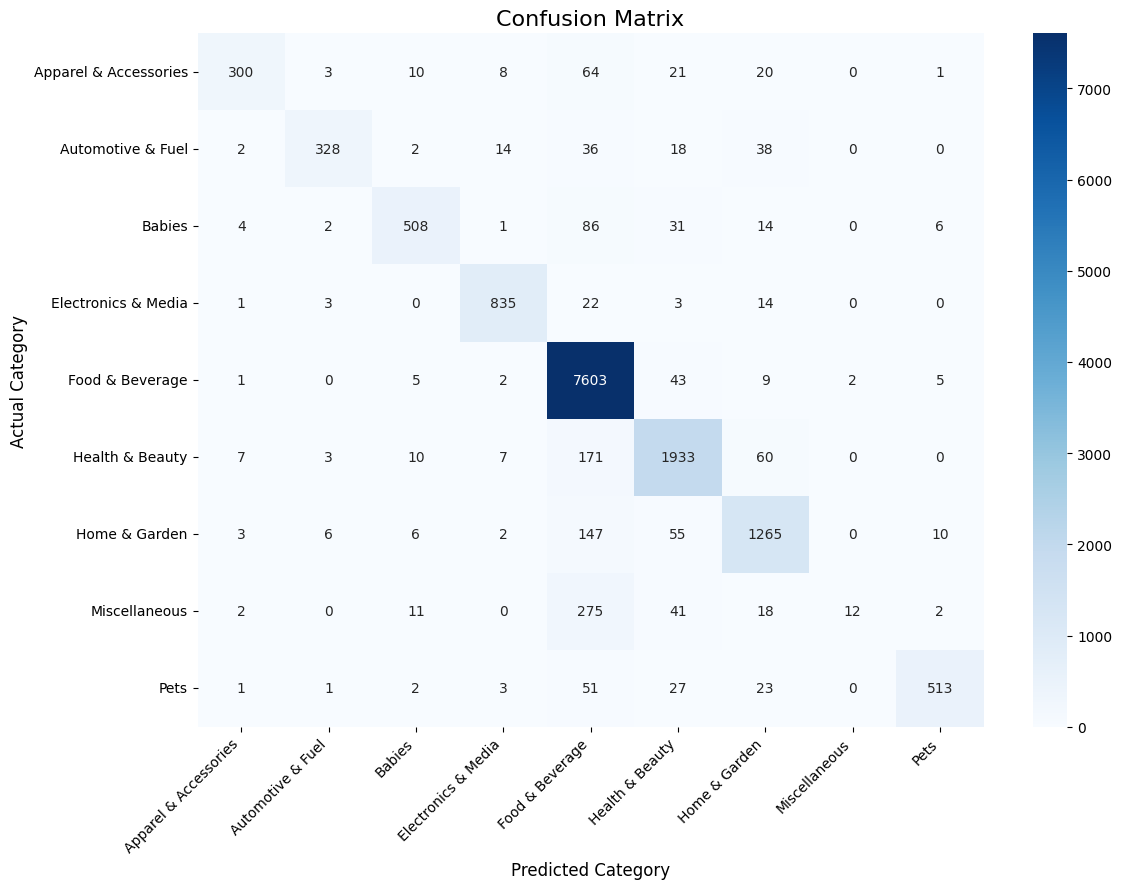


💾 Saving model and vectorizer to: /content/drive/MyDrive/Colab Notebooks/Receipt/

💾 Saving Label Encoder to: /content/drive/MyDrive/Colab Notebooks/Receipt/label_encoder.pkl
✅ Label Encoder saved successfully.
✅ Files saved successfully to your Google Drive.


In [ ]:
import pickle
# TF-IDF
tfidf = TfidfVectorizer(ngram_range=(1, 2))
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)
print("TF-IDF vectorization complete.")
print(f"Vocabulary size: {len(tfidf.get_feature_names_out())} terms")

# Train Logistic Regression Model
model = LogisticRegression(random_state=42, max_iter=2000)
model.fit(X_train_tfidf, y_train)
print("Model training complete.")

# Evaluate the Model Performance
y_pred = model.predict(X_test_tfidf)
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred, target_names=le.classes_)

print(f"\nOverall Model Accuracy: {accuracy:.2%}")
print("\n--- Classification Report: ---")
print(report)

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(12, 9))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.title('Confusion Matrix', fontsize=16)
plt.ylabel('Actual Category', fontsize=12)
plt.xlabel('Predicted Category', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# Save Model and Vectorizer files

vectorizer_path = os.path.join(BASE_DIRECTORY, 'tfidf_vectorizer.pkl')
model_path = os.path.join(BASE_DIRECTORY, 'category_classifier.pkl')
encoder_path = os.path.join(BASE_DIRECTORY, 'label_encoder.pkl')

print(f"\n💾 Saving model and vectorizer to: {BASE_DIRECTORY}")

# Save vectorizer
with open(vectorizer_path, 'wb') as f:
    pickle.dump(tfidf, f)

# Save model
with open(model_path, 'wb') as f:
    pickle.dump(model, f)

print(f"\n💾 Saving Label Encoder to: {encoder_path}")

# Save encoder
with open(encoder_path, 'wb') as f:
    pickle.dump(le, f)

print("✅ Label Encoder saved successfully.")

print("✅ Files saved successfully to your Google Drive.")